In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from littleballoffur import RandomWalkWithRestartSampler
from littleballoffur import ForestFireSampler
from torch_geometric.nn import GCNConv, global_mean_pool, GAE
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import json
import random
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.loader import ClusterData
from torch_geometric.loader import ClusterLoader
from sklearn.decomposition import NMF
from numpy.linalg import svd
import pickle
from scipy.sparse import coo_matrix
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from torch_geometric.utils import to_networkx, from_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors 

# class GCNEncoder(torch.nn.Module):
#         def __init__(self, in_channels, out_channels):
#             super(GCNEncoder, self).__init__()
#             self.conv1 = GCNConv(in_channels, 2 * out_channels)
#             self.conv2 = GCNConv(2 * out_channels, out_channels)
    
#         def forward(self, x, edge_index):
#             x = torch.relu(self.conv1(x, edge_index))
#             x = torch.dropout(x, p=0.2, train=self.training)
#             x = self.conv2(x, edge_index)
#             return x

# class GCNEncoder(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(GCNEncoder, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = torch.dropout(x, p=0.2, train=self.training)
#         x = F.relu(self.conv2(x, edge_index))
#         return x




class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GCNEncoder, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()


        # First layer
        self.layers.append(GCNConv(in_channels, hidden_channels))
        self.batch_norms.append(BatchNorm(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(BatchNorm(hidden_channels))

        # Output layer
        self.layers.append(GCNConv(hidden_channels, out_channels))


    def forward(self, x, edge_index):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.batch_norms[i](self.layers[i](x, edge_index)))
            x = F.dropout(x, p=0.2, training=self.training)
            
        x = F.relu(self.layers[-1](x, edge_index))
        return x

    


class GAEPipeline:
    def __init__(self, in_channels, out_channels, sampling_method='method1', preprocessing=True):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.sampling_method_name = sampling_method
        self.sampling_method = self._get_sampling_method(sampling_method)
        self.preprocessing = preprocessing
        self.encoder = GCNEncoder(in_channels, 64, out_channels, 1).to(self.device)
        self.model = GAE(self.encoder)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

    def recon_loss(self, predicted_adj, true_adj):
        loss = F.binary_cross_entropy(predicted_adj, true_adj)
        return loss

    def load_graph_from_pickle(self, file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

    def _get_sampling_method(self, method_name):
        """Dynamically selects the sampling method."""
        if method_name == 'random_walk':
            return self.random_walk
        elif method_name == 'forest_fire':
            return self.forest_fire
        elif method_name == 'clusterGCN':
            return self.cluster_GCN
        else:
            raise ValueError("Unknown sampling method")

    def convert_node_labels_to_integers(self, graph):
        """
        Convert the node labels of a NetworkX graph to integers.
        
        Parameters:
        - graph: NetworkX graph with any type of node labels.
        
        Returns:
        - A new NetworkX graph with node labels converted to integers.
        """
        # Create a mapping from old labels to new ones (integers)
        mapping = {node: i for i, node in enumerate(graph.nodes())}
        # Use relabel_nodes to create a new graph with integer labels
        graph_int_labels = nx.relabel_nodes(graph, mapping)
        
        return graph_int_labels

    def preprocess_features(self, features):
        # Convert features to a numeric format, handle non-numeric cases
        processed_features = []
        for feature in features:
            try:
                # convert the features to float
                processed_features.append(float(feature))
            except ValueError:
                # Handle non-numeric feature (could implement encoding here)
                processed_features.append(0.0)  # Using 0.0 as a placeholder
        return processed_features

    def normalize_features(self, features):
        features = np.array(features)
        mean = features.mean(axis=0, keepdims=True)
        std = features.std(axis=0, keepdims=True)
        # Avoid division by zero
        std[std == 0] = 1
        normalized_features = (features - mean) / std
        return normalized_features.tolist()

    def from_networkx_to_torch_geometric(self, G):
        # Convert node indices to a continuous range
        mapping = {k: i for i, k in enumerate(G.nodes())}
        edges = torch.tensor([list(map(mapping.get, edge)) for edge in G.edges()], dtype=torch.long).t().contiguous()

        if G.nodes():
            # Extract a sample node to get feature keys (assumes at least one node exists)
            sample_features = next(iter(G.nodes(data=True)))[1]
            feature_keys = list(sample_features.keys())
            
            
            # Extract and preprocess features for all nodes
            features = []
            for _, node_features in G.nodes(data=True):
                node_feature_values = [node_features.get(key, 0) for key in feature_keys]
                processed_features = self.preprocess_features(node_feature_values)
                features.append(processed_features)
            
            # Normalize features
            features = self.normalize_features(features)
        else:
            # Default to a single feature of 0 if no nodes or features
            features = [[0]]
    
        # Convert features to a tensor
        x = torch.tensor(features, dtype=torch.float)
        
        # Create the Data object
        data = Data(x=x, edge_index=edges)
        return data




    
    def random_walk(self, graph):
        graph = self.convert_node_labels_to_integers(graph)
        model = RandomWalkWithRestartSampler(20000)
        new_graph = model.sample(graph)
        return new_graph

    def forest_fire(self, graph):
        graph = self.convert_node_labels_to_integers(graph)
        model = ForestFireSampler(10000)
        new_graph = model.sample(graph)
        return new_graph

    def cluster_GCN(self, data):

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # data = data.to(device)
        torch.manual_seed(12345)
        # Prepare cluster data
        cluster_data = ClusterData(data, num_parts=9) 
        # Create a loader to iterate over clusters
        loader = ClusterLoader(cluster_data, batch_size=1, shuffle=True)  
        
        print()
        total_num_nodes = 0
        for step, sub_data in enumerate(loader):
            print(f'Step {step + 1}:')
            print('=======')
            print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
            print(sub_data)
            print()
            total_num_nodes += sub_data.num_nodes
        
        print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')
        
        return loader

    

    def preprocess_graph(self, graph):
        data = self.from_networkx_to_torch_geometric(graph)
        return data

    def train(self, graph, epochs=100):
        # Preprocessing

        
        # Graph Sampling
        sampled_subgraph = self.sampling_method(graph)

        if self.preprocessing:
            data = self.preprocess_graph(graph).to(self.device)
            
        # data.adj = (data.adj > 0).float()
        # data = Data(edge_index=sampled_subgraph.edge_index, x=sampled_subgraph.x)
        
        # Model Training
        self.model.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            z = self.model.encode(data.x, data.edge_index)
            # adj_recon = self.model.decoder.forward_all(z) 
            # loss = self.recon_loss(adj_recon, data.adj)
            # recon = self.model.decoder(z, data.edge_index, sigmoid=True)
            loss = self.model.recon_loss(z, data.edge_index)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
            # print(f'Epoch {epoch+1}, adj_recon: {adj_recon}')
            
        torch.save(z, f'{self.sampling_method_name}_embedding.pt')


    def train_clusterGCN(self, graph, epochs=1):
        # Preprocessing
        data = self.preprocess_graph(graph)
        # data.adj = (data.adj > 0).float()
        
        # Graph Sampling
        loader = self.cluster_GCN(data)


        # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        criterion = torch.nn.BCELoss() 
        final_embeddings = []
        self.model.train()
        for epoch in range(epochs):  
            total_loss = 0
            epoch_embeddings = [] 
            for batch_idx, batch_data in enumerate(loader):
                # batch_data = batch_data.to(self.device)
                self.optimizer.zero_grad()
                z = self.model.encode(batch_data.x, batch_data.edge_index)
                loss = self.model.recon_loss(z, batch_data.edge_index)
                # recon = self.model.decoder.forward(z, cluster.edge_index, sigmoid=True)
                # adj_recon = self.model.decoder(z, cluster.edge_index)
                # loss = F.binary_cross_entropy_with_logits(z, adj_recon)
                loss.backward()
                self.optimizer.step()
                epoch_embeddings.append(z.detach().cpu().numpy())  # Collect embeddings
        
                total_loss += loss.item()
            avg_loss = total_loss / len(loader)
            print(f"Epoch {epoch+1}, Average Loss: {loss.item()}")
            if epoch == epochs - 1:
                final_embeddings = np.concatenate(epoch_embeddings, axis=0)
            
                
        torch.save(torch.from_numpy(final_embeddings), f'{self.sampling_method_name}_embedding.pt')


    def non_negative_matrix_factorization(self, graph):
        subgraph = self.sampling_method(graph)
        
        A = nx.to_numpy_array(subgraph)
        print(A.shape)
        model = NMF(n_components=2, init='random', random_state=0)
        
        # Fit the model to the adjacency matrix and transform
        W = model.fit_transform(A)  # Basis matrix (features)
        H = model.components_  # Coefficient matrix (components)
        return W, H


    def cluster(self, embeddings, cluster_algorithm):
        """
        Clusters embeddings using the provided clustering algorithm and visualizes the results using t-SNE.
        
        Parameters:
        embeddings (array-like): The embeddings to cluster, shape (n_samples, n_features).
        cluster_algorithm: An instance of a clustering algorithm.
        
        Returns:
        None
        """

        labels = cluster_algorithm.fit_predict(embeddings)
        

        silhouette = silhouette_score(embeddings, labels)
        calinski_harabasz = calinski_harabasz_score(embeddings, labels)
        davies_bouldin = davies_bouldin_score(embeddings, labels)
        

        print("Silhouette Score:", silhouette)
        print("Calinski-Harabasz Index:", calinski_harabasz)
        print("Davies-Bouldin Index:", davies_bouldin)
        return labels

    def visualize_embeddings(self, embeddings, labels=None):
        """
        Visualize embeddings using t-SNE.
    
        :param embeddings: A numpy array of shape (n_samples, n_features) containing the embeddings.
        :param labels: Optional. A list or array of labels for each embedding. If provided, points will be colored according to their label.
        """
        # Create a t-SNE model
        tsne = TSNE(n_components=2, random_state=10, learning_rate='auto', init='random')
    
        # Reduce dimensions
        embeddings_2d = tsne.fit_transform(embeddings)
    
        # Plotting
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
        
        if labels is not None:
            plt.colorbar(scatter)
        
        plt.title('t-SNE visualization of embeddings')
        plt.xlabel('t-SNE feature 1')
        plt.ylabel('t-SNE feature 2')
        plt.show()


    def knn(self, embeddings, k):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(embeddings)
        distances, indices = nbrs.kneighbors(embeddings)
        return distances, indices










In [ ]:
      
pipeline = GAEPipeline(in_channels=11, out_channels=30, sampling_method='random_walk')
graph = pipeline.load_graph_from_pickle('combined_graph.pkl')
pipeline.train(graph)

In [20]:
import pandas as pd

bio_df = pd.read_excel('data/expression_data.xlsx', engine='openpyxl')
bio_df = bio_df.drop(bio_df.columns[0], axis=1)
proteins = bio_df.columns.tolist()
uniprot_to_reactome = pd.read_csv('data/MMU_Uniprot2Reactome.txt', sep='\t')

existing_proteins = uniprot_to_reactome[uniprot_to_reactome['V1'].isin(proteins)]['V1'].unique()

existing_proteins_list = existing_proteins.tolist()
# existing_proteins_list

In [21]:
# graph = nx.read_graphml("aggregated_proteins_v70_subgraph.graphml")
pipeline = GAEPipeline(in_channels=11, out_channels=64, sampling_method='clusterGCN')
graph = pipeline.load_graph_from_pickle('combined_graph_latest.pkl')

mapping = {node: i for i, node in enumerate(graph.nodes())}
schema_attr = nx.get_node_attributes(graph, "schemaClass")
proteins = [node for node, schema in schema_attr.items() if schema == 'EntityWithAccessionedSequence']
# print("Indices of nodes with schemaClass 'EntityWithAccessionedSequence':", proteins)
protein_indices_in_pyg = [mapping[node] for node in proteins if node in mapping]
print("Indices of proteins in PyTorch Geometric tensor:", len(protein_indices_in_pyg))
# pipeline.train_clusterGCN(graph)


Indices of proteins in PyTorch Geometric tensor: 23664


In [ ]:
pipeline = GAEPipeline(in_channels=11, out_channels=64, sampling_method='clusterGCN')
graph = pipeline.load_graph_from_pickle('combined_graph_latest.pkl')

existing_proteins_set = set(existing_proteins_list)

mapping = {node: i for i, node in enumerate(graph.nodes())}
schema_attr = nx.get_node_attributes(graph, "schemaClass")
name_attr = nx.get_node_attributes(graph, "name")


proteins = []
processed_proteins = set()

# Iterate over each node and its schema attribute
for node, schema in schema_attr.items():
    if schema == 'EntityWithAccessionedSequence':
        name_string = name_attr.get(node, "")
        if name_string:
            name_list = [name.strip(' "[]') for name in name_string.split(',')]
            matched_names = set(name_list) & existing_proteins_set
            if matched_names:
                new_matches = matched_names - processed_proteins
                if new_matches:
                    # print(f"Matched names for node {node}: {new_matches}")
                    proteins.append(node)
                    processed_proteins.update(new_matches)


# Convert node identifiers to indices in the PyTorch Geometric tensor
protein_indices_in_pyg = [mapping[node] for node in proteins if node in mapping]

print("Indices of desired proteins in PyTorch Geometric tensor:", len(protein_indices_in_pyg))
proteins

In [40]:
graph.nodes[215292]

{'schemaClass': 'EntityWithAccessionedSequence',
 'speciesName': 'Mus musculus',
 'startCoordinate': 1,
 'isInDisease': False,
 'displayName': 'Iglc1 [extracellular region]',
 'stIdVersion': 'R-MMU-197041.1',
 'dbId': 9865079,
 'name': '["Iglc1", "IGKC", "A0A0G2JE99"]',
 'referenceType': 'ReferenceGeneProduct',
 'endCoordinate': 106,
 'stId': 'R-MMU-197041'}

In [28]:
Z = torch.load('clusterGCN_embedding.pt').detach().numpy()
protein_embeddings = Z[protein_indices_in_pyg]


print("Protein Embeddings:")
print(protein_embeddings)
# for p in protein_embeddings:
#     print(p)

Protein Embeddings:
[[ 0.12752588 -0.08046311 -0.08814774 ... -0.12544289 -0.01445178
  -0.07764287]
 [ 0.43330938  0.17426711 -0.34056967 ... -0.08468823  0.26146626
   0.27944002]
 [ 0.14435521 -0.17989095  0.15285406 ... -0.06028442 -0.11390051
   0.12521541]
 ...
 [ 0.12688142 -0.07444928  0.38620216 ...  0.29281712  0.22770575
   0.695283  ]
 [ 0.10435061  0.07807729 -0.21531942 ... -0.16170457 -0.02762629
   0.04571901]
 [ 0.22350854 -0.02924071 -0.1481502  ... -0.09483119 -0.0918192
   0.2974335 ]]


In [ ]:
from collections import defaultdict

def analyze_dbid_repetitiveness(graph):
    dbid_count = defaultdict(int)
    
    # Count each dbId occurrence
    for _, attrs in graph.nodes(data=True):
        dbid = attrs.get('displayName')  # Safely get the dbId attribute, if it exists
        if dbid is not None:
            dbid_count[dbid] += 1

    # Check for repetitive dbIds and print a summary
    repetitive_dbids = {dbid: count for dbid, count in dbid_count.items() if count > 1}
    if repetitive_dbids:
        print("Summary of repetitive names:")
        for dbid, count in repetitive_dbids.items():
            print(f"display name {dbid} repeats {count} times")
    else:
        print("No repetitive dbIds found.")

    return repetitive_dbids

analyze_dbid_repetitiveness(graph)

## Check out the attributes of nodes in the graph

In [10]:

pipeline = GAEPipeline(in_channels=11, out_channels=64, sampling_method='clusterGCN')
graph = pipeline.load_graph_from_pickle('combined_graph_latest.pkl')

nodes_without_attrs = []
count = 1
for node, attrs in graph.nodes(data=True):
    if not attrs:
        nodes_without_attrs.append(node)
    elif attrs:
            count+=1

print("numnber of nodes without attributes", len(nodes_without_attrs))
print("number of nodes with attributes",count)


numnber of nodes without attributes 0
number of nodes with attributes 50165


In [ ]:
graph.nodes[215046]

In [24]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

# x = euclidean_distances(protein_embeddings)
x = cosine_distances(protein_embeddings)


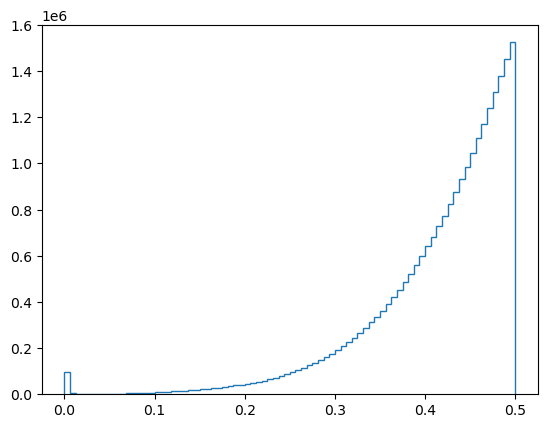

In [25]:

arr = x.reshape((-1,))
counts, bins = np.histogram(arr, bins=80, range=(0, 0.5))
plt.stairs(counts, bins)
plt.show()

/home/fatemeh/anaconda3/envs/GNNenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.99416244
Calinski-Harabasz Index: 55271.61605140941
Davies-Bouldin Index: 0.29176195588222964


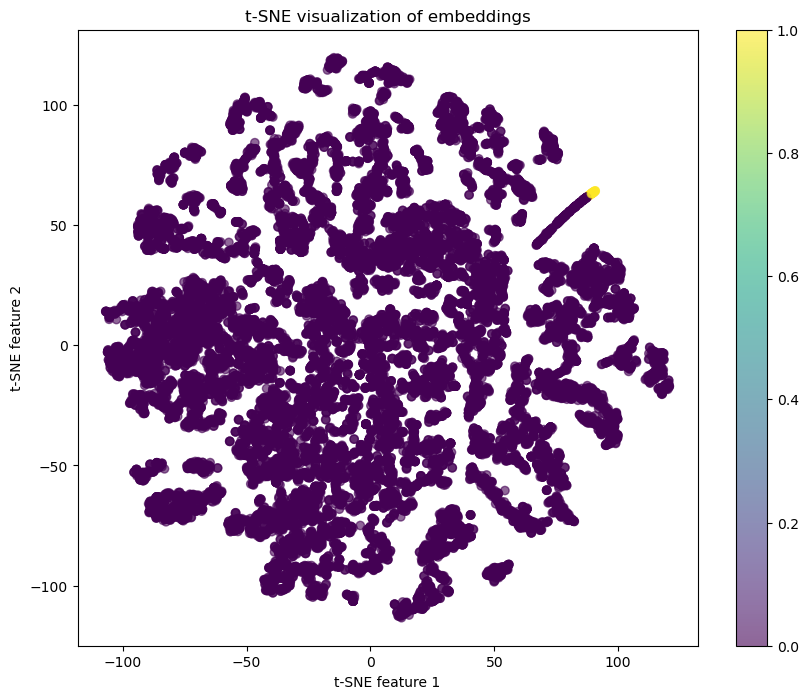

In [32]:

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

pipeline = GAEPipeline(in_channels=11, out_channels=32, sampling_method='clusterGCN')
Z = torch.load('clusterGCN_embedding_leakyR.pt').detach().numpy()
protein_embeddings = Z[protein_indices_in_pyg]

kmeans = KMeans(n_clusters=2)
# agg_clust = AgglomerativeClustering(n_clusters=7,  affinity='euclidean', linkage='ward')
# dbscan = DBSCAN(eps=0.01, min_samples=4)
# spec = SpectralClustering(n_clusters=7,random_state=0)
# protein_embeddings = normalize(protein_embeddings, norm='l2', axis=1)
# print(protein_embeddings)
labels = pipeline.cluster(protein_embeddings, kmeans)
pipeline.visualize_embeddings(protein_embeddings, labels)


/home/fatemeh/anaconda3/envs/GNNenv/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score: 0.2358154
Calinski-Harabasz Index: 5905.287838143517
Davies-Bouldin Index: 1.6541913607616539


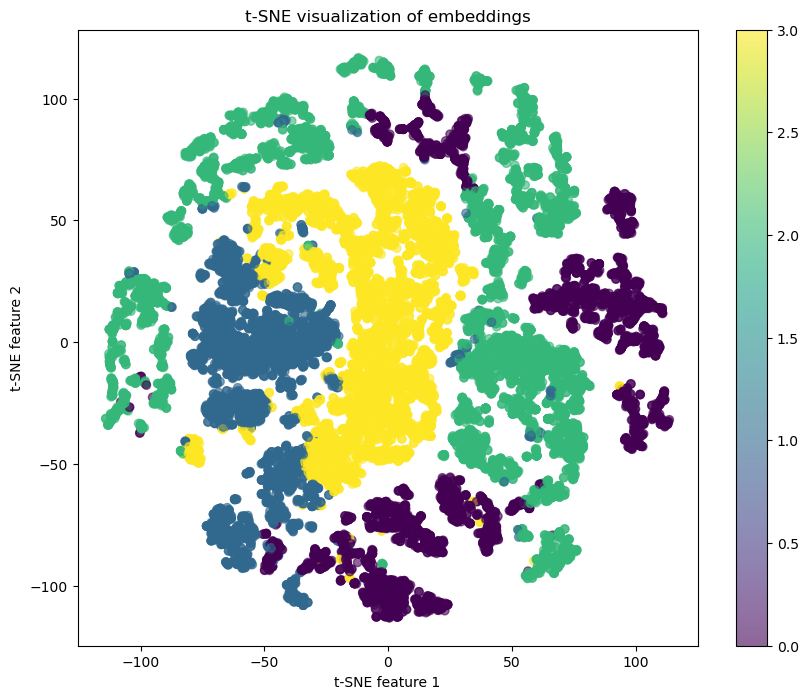

In [35]:
pipeline = GAEPipeline(in_channels=11, out_channels=32, sampling_method='clusterGCN')
Z = torch.load('clusterGCN_embedding_leakyR.pt').detach().numpy()
protein_embeddings = Z[protein_indices_in_pyg]

agg_clust = AgglomerativeClustering(n_clusters=4,  affinity='euclidean', linkage='ward')
protein_embeddings = normalize(protein_embeddings, norm='l2', axis=1)
# print(protein_embeddings)
labels = pipeline.cluster(protein_embeddings, agg_clust)
pipeline.visualize_embeddings(protein_embeddings, labels)

## Subset Selection

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

train = pd.read_csv('data/train.csv', index_col=0)
target = 'group'

features = train.columns.tolist()
features.remove(target)

matched_set = processed_proteins.intersection(features)
features = list(matched_set)
print("Matched items:", len(features))


best = []
acc = {}
while len(best) < 3:
    max_acc = 0
    remaining_features = list(set(features) - set(best))
    new_pval = pd.Series(index=remaining_features)
    for new_column in remaining_features:
        model = LogisticRegression()
        model.fit(train[best + [new_column]], train[target])
        target_predicted = model.predict(train[best + [new_column]])
        acc = metrics.accuracy_score(train[target], target_predicted)
        if max_acc < acc:
            max_acc = acc
            max_column = new_column
            
    best.append(max_column)
    features.remove(max_column)
    print('Best columns: ', best)
    print('Accuracy: ', max_acc)

Matched items: 1510


/tmp/ipykernel_15849/2153066589.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Best columns:  ['Q7TN37']
Accuracy:  1.0


/tmp/ipykernel_15849/2153066589.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Best columns:  ['Q7TN37', 'Q02053']
Accuracy:  1.0


/tmp/ipykernel_15849/2153066589.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Best columns:  ['Q7TN37', 'Q02053', 'P70700']
Accuracy:  1.0


In [74]:
nn = NearestNeighbors(n_neighbors=1) 
nn.fit(train[features].T )

# Find indices of the 3 nearest neighbors to the best feature
distances, indices = nn.kneighbors(train[best].T)

# Get the feature names corresponding to the nearest indices
# Exclude the first one if it's the best feature itself
neighbor_features = [features[idx] for idx in indices[0] if features[idx] != best[0]]

print('Neighbors:', neighbor_features)
print('Neighbors:', distances)

Neighbors: ['Q9CQ73']
Neighbors: [[0.54048835]
 [0.48552484]
 [0.68730745]]


In [82]:
model = LogisticRegression()
new_feature_set = [best[2]] + neighbor_features
model.fit(train[new_feature_set], train[target])
target_predicted = model.predict(train[new_feature_set])
new_acc = metrics.accuracy_score(train[target], target_predicted)

print('New Best Features:', new_feature_set)
print('New Accuracy:', new_acc)

New Best Features: ['P70700', 'Q9CQ73']
New Accuracy: 0.9166666666666666


In [78]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

def select_features_and_predict(train_data_path, target, processed_proteins, num_best_features, num_neighbors):
    # Load data
    train = pd.read_csv(train_data_path, index_col=0)

    # Set up features
    features = train.columns.tolist()
    features.remove(target)
    matched_set = processed_proteins.intersection(features)
    features = list(matched_set)
    print("Matched items:", len(features))

    best = []
    max_acc = 0
    all_features = features[:]  # Copy to retain the original features for neighbor selection

    # Feature selection loop
    while len(best) < num_best_features:
        max_acc = 0
        remaining_features = list(set(features) - set(best))
        for new_column in remaining_features:
            model = LogisticRegression()
            if best:
                model.fit(train[best + [new_column]], train[target])
                target_predicted = model.predict(train[best + [new_column]])
            else:
                # Handle the case where best is empty (first iteration)
                model.fit(train[[new_column]], train[target])
                target_predicted = model.predict(train[[new_column]])
            acc = metrics.accuracy_score(train[target], target_predicted)
            if acc > max_acc:
                max_acc = acc
                max_column = new_column
                
        best.append(max_column)
        features.remove(max_column)
        print('Best columns:', best)
        print('Accuracy:', max_acc)


    return best

best_features = select_features_and_predict('data/train.csv', 'group', processed_proteins, 4, 4)

Matched items: 1510
Best columns: ['Q91YS8']
Accuracy: 1.0
Best columns: ['Q91YS8', 'P01027']
Accuracy: 1.0
Best columns: ['Q91YS8', 'P01027', 'Q7TSS2']
Accuracy: 1.0
Best columns: ['Q91YS8', 'P01027', 'Q7TSS2', 'Q9CXE7']
Accuracy: 1.0


## KNN

In [79]:
def map_names_to_tensor_indices(names, pipeline, existing_proteins_list, graph_path='combined_graph_latest.pkl'):
    # Load the graph
    graph = pipeline.load_graph_from_pickle(graph_path)
    
    # Convert the existing proteins list to a set
    existing_proteins_set = set(existing_proteins_list)
    
    # Create a mapping from node to index
    mapping = {node: i for i, node in enumerate(graph.nodes())}
    
    # Get node attributes for schemaClass and name
    schema_attr = nx.get_node_attributes(graph, "schemaClass")
    name_attr = nx.get_node_attributes(graph, "name")
    
    # Initialize containers for proteins and processed proteins
    proteins = []
    processed_proteins = set()
    
    # Iterate over each node and its schema attribute
    for node, schema in schema_attr.items():
        if schema == 'EntityWithAccessionedSequence':
            name_string = name_attr.get(node, "")
            if name_string:
                name_list = [name.strip(' "[]') for name in name_string.split(',')]
                matched_names = set(name_list) & existing_proteins_set
                if matched_names:
                    new_matches = matched_names - processed_proteins
                    if new_matches:
                        proteins.append(node)
                        processed_proteins.update(new_matches)
    
    # Convert node identifiers to indices in the PyTorch Geometric tensor
    protein_indices_in_pyg = [mapping[node] for node in proteins if node in mapping]
    # Find the indices for the given names
    name_indices = []
    for name in names:
        name_index = None
        for node in proteins:
            name_string = name_attr.get(node, "")
            name_list = [name.strip(' "[]') for name in name_string.split(',')]
            if name_string and name in name_list:
                name_index = mapping.get(node)
                break
        name_indices.append(name_index)
    
    return name_indices



pipeline = GAEPipeline(in_channels=11, out_channels=64, sampling_method='clusterGCN')



index = map_names_to_tensor_indices(best_features, pipeline, existing_proteins_list)
print("Index of the desired protein in the PyTorch Geometric tensor:", index)


Index of the desired protein in the PyTorch Geometric tensor: [32054, 6113, 36496, 39366]


In [80]:
Z = torch.load('clusterGCN_embedding_leakyR.pt').detach().numpy()
best_feature_embedding = Z[index]

In [81]:
best_features

['Q91YS8', 'P01027', 'Q7TSS2', 'Q9CXE7']

In [82]:
best_feature_embedding

array([[-4.26657289e-01, -1.40827030e-01, -1.23063587e-01,
        -2.30088606e-02, -2.20480368e-01, -3.88036251e-01,
        -1.52066335e-01, -2.07145691e-01, -9.07298103e-02,
        -3.40183944e-01, -1.00470651e-02, -9.53735113e-02,
        -1.27775976e-02, -1.57616306e-02, -3.20708007e-01,
        -9.65038687e-03, -2.65544094e-02, -1.70410901e-01,
        -7.39086866e-02, -1.55609688e-02, -1.52810980e-02,
        -6.26223255e-03, -1.16078354e-01, -5.71739599e-02,
        -2.80323122e-02, -2.55038962e-02, -2.02831533e-02,
        -2.84053423e-02, -3.08636706e-02, -3.75249569e-04,
        -1.03588276e-01, -2.54607014e-03],
       [-3.54878992e-01, -1.70571253e-01, -9.76785943e-02,
        -1.63876228e-02, -5.97085655e-01, -2.73853540e-01,
        -9.95934248e-01, -1.05095230e-01, -4.32611741e-02,
        -4.32344854e-01, -3.08932178e-03, -1.34380847e-01,
        -1.67149398e-02, -2.60408558e-02, -7.58221090e-01,
        -2.39457358e-02, -2.40299199e-02, -1.02253132e-01,
        -8.08

In [83]:
# best_feature_embedding = best_feature_embedding.reshape(1, -1)
knn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean')
knn.fit(best_feature_embedding)


distances, indices = knn.kneighbors(best_feature_embedding)
print("Nearest Neighbors Indices:", indices)
print("Distances:", distances)

Nearest Neighbors Indices: [[0 2]
 [1 0]
 [2 3]
 [3 2]]
Distances: [[0.00000000e+00 1.19040070e+00]
 [5.96046448e-08 2.87614203e+00]
 [7.45058060e-09 9.66439568e-01]
 [0.00000000e+00 9.66439568e-01]]


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def calculate_and_plot_similarity_matrix(embeddings):

    # Calculate the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=False, cmap='viridis')
    plt.title("Cosine Similarity Matrix Heatmap")
    plt.xlabel("Embeddings")
    plt.ylabel("Embeddings")
    plt.show()

# Example usage:
# Assuming `best_feature_embedding` is your 2D array of embeddings
# best_feature_embedding = np.array([...])  # Replace with your actual embeddings

calculate_and_plot_similarity_matrix(best_feature_embedding)